MICE + XGBoost + Regularized Linear Models

This notebook implements MICE (Multiple Imputation by Chained Equations) in fields with missing values.
Models used: XGBoost, LassoCV, RidgeCV combined with feature selection.
Feature engineering: one-hot encoding
Feature scaling: standardization (centering and scaling) of dataset that removes mean and scales to unit variance. It is necessary for machine learning estimators.
Outlier identification: based on LassoCV it compares rmse with residual of every point predicted vs. actual.
Feature agglomeration: clustering of highly correlated features
Validation of models by split of training set and plotting predicted vs. actual.

Data Cleaning using Class (python OOP) 
----------
We will use a class to hold all our important methods, which is the easiest
way to generalize our analysis to treat many cases with few code
changes.

In [3]:
class HousePrices(object):
    import numpy as np
    import pandas as pd
    # import matplotlib
    # matplotlib.use('TkAgg')
    import pylab as plt
    from fancyimpute import MICE
    # import sys
    # sys.path.append('/custom/path/to/modules')
    import random
    # from sklearn.model_selection import cross_val_score
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from scipy.stats import skew
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold, train_test_split
    from sklearn.linear_model import LassoCV
    from sklearn.ensemble import IsolationForest
    import xgboost as xgb
    from sklearn.preprocessing import StandardScaler, LabelBinarizer
    import xgboost as xgb
    from matplotlib.backends.backend_pdf import PdfPages
    import datetime
    from sklearn.cluster import FeatureAgglomeration
    import seaborn as sns
    # import math

    def __init__(self):
        self.df = HousePrices.df
        self.df_test = HousePrices.df_test
        self.df_all_feature_var_names = []
        self.df_test_all_feature_var_names = []
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%Hh%Mm%Ss')
        self.is_with_log1p_SalePrice = 0

    # Private variables
    _non_numerical_feature_names = []
    _numerical_feature_names = []
    _is_one_hot_encoder = 0
    _feature_names_num = []
    _save_path = 'C:\\Users\\Lourdes\\Downloads\\'
    _is_not_import_data = 0
    _is_dataframe_with_sale_price = 1

    ''' Pandas Data Frame '''
    df = pd.read_csv('C:\\Users\\Lourdes\\Downloads\\train.csv', header=0)
    df_test = pd.read_csv('C:\\Users\\Lourdes\\Downloads\\test.csv', header=0)

    @staticmethod
    def square_feet_to_meters(area):
        square_meter_per_square_feet = 0.3048**2
        return area*square_meter_per_square_feet

    @staticmethod
    def extract_numerical_features(df):
        df = df.copy()
        # Identify numerical columns which are of type object
        numerical_features = pd.Series(data=False, index=df.columns, dtype=bool)

        for feature in df.columns:
            if any(tuple(df[feature].apply(lambda x: type(x)) == int)) or \
                            any(tuple(df[feature].apply(lambda x: type(x)) == float)) & \
                            (not any(tuple(df[feature].apply(lambda x: type(x)) == str))):
                numerical_features[feature] = 1
        return numerical_features[numerical_features == 1].index

    @staticmethod
    def extract_non_numerical_features(df):
        df = df.copy()
        return df.select_dtypes(exclude=[np.number])

    def clean_data(self, df):
        df = df.copy()
        is_with_MICE = 1
        if df.isnull().sum().sum() > 0:
            if is_with_MICE:
                # Imputation using MICE
                numerical_features_names = self.extract_numerical_features(df)
                df.loc[:, tuple(numerical_features_names)] = self.estimate_by_mice(
                    df[numerical_features_names])
            else:
                if any(tuple(df.columns == 'SalePrice')):
                    df = df.dropna()
                else:
                    df = df.dropna(1)
                    HousePrices._feature_names_num = pd.Series(data=np.intersect1d(
                        HousePrices._feature_names_num.values, df.columns), dtype=object)
        return df

    @staticmethod
    def encode_labels_in_numeric_format(df, estimated_var):
        # Transform non-numeric labels into numerical values
        # Cons.: gives additional unwanted structure to data, since some values are high and 
        # others low, despite labels
        # where no such comparing measure exists.
        # Alternative: use one-hot-encoding giving all labels their own column represented with 
        # only binary values.
        feature_name_num = ''.join([estimated_var, 'Num'])
        mask = ~df[estimated_var].isnull()
        df[feature_name_num] = df[estimated_var]
        df.loc[mask, tuple([feature_name_num])] = df[estimated_var].factorize()[0][
            mask[mask == 1].index]

    @staticmethod
    def label_classes(df, estimated_var):
        le = LabelEncoder()
        le.fit(df[estimated_var].values)
        return le.classes_

    @staticmethod
    def one_hot_encoder(df, estimated_var):
        df_class = df.copy()
        ohe = OneHotEncoder()
        label_classes = df_class[estimated_var].factorize()[1]
        new_one_hot_encoded_features = [''.join([estimated_var, '_', x]) for x in label_classes]
        mask = ~df[estimated_var].isnull()
        feature_var_values = ohe.fit_transform(np.reshape(np.array(
            df[''.join([estimated_var, 'Num'])][mask].values), 
                                                          (df[mask].shape[0], 
                                                           1))).toarray().astype(int)
        # Create new feature_var columns with one-hot encoded values
        for ite in new_one_hot_encoded_features:
            df[ite] = df[estimated_var]
        df.loc[mask, tuple(new_one_hot_encoded_features)] = feature_var_values

    @staticmethod
    def add_feature_var_name_with_zeros(df, feature_var_name):
        df[feature_var_name] = np.zeros((df.shape[0], 1), dtype=int)
        pass

    @staticmethod
    def feature_var_names_in_training_set_not_in_test_set(feature_var_names_training, 
                                                          feature_var_names_test):
        feature_var_name_addition_list = []
        for feature_var_name in feature_var_names_training:
            if not any(tuple(feature_var_name == feature_var_names_test)):
                feature_var_name_addition_list.append(feature_var_name)
        return np.array(feature_var_name_addition_list)

    def feature_mapping_to_numerical_values(self, df):
        HousePrices._is_one_hot_encoder = 0
        mask = ~df.isnull()
        # Assume that training set has all possible feature_var_names
        # Although it may occur in real life that a training set may hold a feature_var_name. 
        # But it is probably
        # avoided since such features cannot
        # be part of the trained learning algo.
        # Add missing feature_var_names of traning set not occuring in test set. Add these with 
        # zeros in columns.
        if not any(tuple(df.columns == 'SalePrice')):
            # All one-hot encoded feature var names occuring in test data is assigned the private 
            # public varaible
            # df_test_all_feature_var_names.
            self.df_test_all_feature_var_names = df.columns

        _feature_names_num = np.zeros((HousePrices._non_numerical_feature_names.shape[0],), 
                                      dtype=object)
        ith = 0
        for feature_name in HousePrices._non_numerical_feature_names:
            # Create a feature_nameNum list
            feature_name_num = ''.join([feature_name, 'Num'])
            _feature_names_num[ith] = feature_name_num
            ith += 1
            HousePrices.encode_labels_in_numeric_format(df, feature_name)

            if HousePrices._is_one_hot_encoder:
                is_with_label_binarizer = 0
                if is_with_label_binarizer:
                    if feature_name == 'MasVnrType':
                        print('debug')
                    # feature_var_values = mapper_df.fit_transform(df[feature_name][
                    #     mask[feature_name]])
                    mapper_df = DataFrameMapper([(feature_name, LabelBinarizer())], df_out=True)
                    # Check if we need to merge our result into df
                    feature_var_values = mapper_df.fit_transform(df.copy())
                    print(df[feature_name].isnull().sum().sum())
                    print(df[feature_name][mask[feature_name]].isnull().sum().sum())
                    for ite in feature_var_values.columns:
                        df[ite] = feature_var_values[ite]
                else:
                    HousePrices.one_hot_encoder(df, feature_name)
        HousePrices._feature_names_num = pd.Series(data=_feature_names_num, dtype=object)

    @staticmethod
    def feature_agglomeration(df, number_of_clusters=int(df.shape[1] / 1.2)):
        df = df.copy()
        # Todo: find optimal number of clusters for the feature clustering
        # number_of_clusters = int(df.shape[1]/2)

        agglomerated_features = FeatureAgglomeration(n_clusters=number_of_clusters)
        # mask = ~df[features].isnull()
        # mask_index = mask[mask == 1].index
        if any(tuple(df.columns == 'SalePrice')):
            res = agglomerated_features.fit_transform(np.reshape(np.array(df.dropna().values), 
                                                                 df.dropna().shape), 
                                                      y=df.SalePrice.values)
        else:
            res = agglomerated_features.fit_transform(np.reshape(np.array(df.values), df.shape))

        # Obs. case of adding values using df.loc[], remember mask is only possible for a 
        # single feature at a time.
        # print(''.join(['labels:', str(agglomerated_features.labels_)]))
        # print(''.join(['Children:', str(agglomerated_features.children_)]))
        # print(''.join(['number of leaves in the hierarchical tree:', 
        #                str(agglomerated_features.n_leaves_)]))
        # HousePrices.dendrogram(df)
        df = pd.DataFrame(data=res)
        return df

    @staticmethod
    def dendrogram(df, number_of_clusters=int(df.shape[1] / 1.2)):
        # Create Dendrogram
        agglomerated_features = FeatureAgglomeration(n_clusters=number_of_clusters)
        used_networks = np.arange(0, number_of_clusters, dtype=int)
        # used_networks = np.unique(agglomerated_features.labels_)

        # In our case all columns are clustered, which means used_columns is true in every element
        # used_columns = (df.columns.get_level_values(None)
                        # .astype(int)
                        # .isin(used_networks))
        # used_columns = (agglomerated_feature_labels.astype(int).isin(used_networks))
        # df = df.loc[:, used_columns]

        # Create a custom palette to identify the networks
        network_pal = sns.cubehelix_palette(len(used_networks),
                                            light=.9, dark=.1, reverse=True,
                                            start=1, rot=-2)
        network_lut = dict(zip(map(str, df.columns), network_pal))

        # Convert the palette to vectors that will be drawn on the side of the matrix
        networks = df.columns.get_level_values(None)
        network_colors = pd.Series(networks, index=df.columns).map(network_lut)
        sns.set(font="monospace")
        # Create custom colormap
        cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
        cg = sns.clustermap(df.astype(float).corr(), cmap=cmap, linewidths=.5, 
                            row_colors=network_colors, col_colors=network_colors)
        plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
        plt.show()


    def feature_engineering(self, df):
        # df['LotAreaSquareMeters'] = self.square_feet_to_meters(df.LotArea.values)

        is_skewness_correction_for_all_features = 1
        if is_skewness_correction_for_all_features:
            # Correcting for skewness
            # Treat all numerical variables that were not one-hot encoded
            if any(tuple(df.columns == 'SalePrice')):
                self.is_with_log1p_SalePrice = 1

            numerical_feature_names_of_non_modified_df = HousePrices._numerical_feature_names

            if HousePrices._is_one_hot_encoder:
                numerical_feature_names_of_non_modified_df = numerical_feature_names_of_non_modified_df.values
            else:
                numerical_feature_names_of_non_modified_df = np.concatenate([
                    HousePrices._feature_names_num.values, 
                    numerical_feature_names_of_non_modified_df.values])

            relevant_features = df[numerical_feature_names_of_non_modified_df].columns[
                (df[numerical_feature_names_of_non_modified_df].columns != 'Id')]
            self.skew_correction(df, relevant_features)
        else:
            # Only scale down sale price, since all leave other numerical features standardized.
            if any(tuple(df.columns == 'SalePrice')):
                # self.skew_correction(df, 'SalePrice')  # dropna complaining since no nulls
                self.is_with_log1p_SalePrice = 1
                df.loc[:, tuple(['SalePrice'])] = np.log1p(df.SalePrice)

    @staticmethod
    def skew_correction(df, numerical_features):
        # Skew correction
        # compute skewness
        skewed_feats = df[numerical_features].apply(lambda x: skew(x.dropna()))  
        skewed_feats = skewed_feats[skewed_feats > 0.75]
        skewed_feats = skewed_feats.index
        df.loc[:, tuple(skewed_feats)] = np.log1p(np.asarray(df[skewed_feats], dtype=float))
        # df[skewed_feats] = np.log1p(np.asarray(df[skewed_feats], dtype=float))

    @staticmethod
    def outlier_prediction(x_train, y_train):
        # Use built-in isolation forest or use predicted vs. actual
        # Compute squared residuals of every point
        # Make a threshold criteria for inclusion

        # The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
        rng = np.random.RandomState(42)
        clf_all_features = IsolationForest(max_samples=100, random_state=rng)
        clf_all_features.fit(x_train)

        # Predict if a particular sample is an outlier using all features for higher dimensional 
        # data set.
        y_pred_train = clf_all_features.predict(x_train)

        # Exclude suggested outlier samples for improvement of prediction power/score
        outlier_map_out_train = np.array(map(lambda x: x == 1, y_pred_train))
        x_train_modified = x_train[outlier_map_out_train, ]
        y_train_modified = y_train[outlier_map_out_train, ]

        return x_train_modified, y_train_modified

    def drop_variable_before_preparation(self, df):
        # Acceptable limit of NaN in features
        limit_of_nans = 0.3*df.shape[0]
        # limit_of_nans = 800
        for feature in self.features_with_missing_values_in_dataframe(df).index:
            if df[feature].isnull().sum() > limit_of_nans:
                df = df.drop([feature], axis=1)

        # df = df.drop(['Alley'], axis=1)
        # df = df.drop(['MasVnrType'], axis=1)
        # df = df.drop(["Utilities", "LotFrontage", "Alley", "MasVnrType", "MasVnrArea", 
        #               "BsmtQual",
        #               "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
        #               "Electrical", "FireplaceQu", "GarageType", "GarageYrBlt",
        #               "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
        #               "Fence", "MiscFeature"], axis=1)
        return df

    def drop_variable(self, df):
        # df = df.drop(['Fireplaces'], axis=1)
        df = df.drop(['Id'], axis=1)

        if not any(tuple(df.columns == 'SalePrice')):
            # All feature var names occuring in test data is assigned the public varaible 
            # df_test_all_feature_var_names.
            self.df_test_all_feature_var_names = df.columns
        return df

    def save_dataframe(self, df):
        if HousePrices._is_dataframe_with_sale_price:
            df.to_csv(''.join([HousePrices._save_path, 'train_debug', self.timestamp, '.csv']), 
                      columns=df.columns, index=False)
        else:
            df.to_csv(''.join([HousePrices._save_path, 'test_debug', self.timestamp, '.csv']), 
                      columns=df.columns, index=False)

    @staticmethod
    def load_dataframe():
        if HousePrices._is_dataframe_with_sale_price:
            dataframe_name = 'train_debug'
        else:
            dataframe_name = 'test_debug'

        # one-hot encoded
        # date_time = '20170227_11h46m53s'  # has num col
        # date_time = '20170227_12h19m16s'  # has num col
        # date_time = '20170227_15h36m21s'  # has num col
        # corrected below
        # date_time = '20170227_16h50m45s'  # has bug in prediction
        date_time = '20170228_10h50m23s'
        # not one-hot
        # date_time = '20170226_19h53m38s'
        # date_time = '20170227_14h51m53s'
        # date_time = '20170227_15h04m15s'
        # date_time = '20170227_15h57m09s'
        # date_time = '20170227_16h04m23s'
        # corrected below
        # date_time = '20170228_00h05m40s'
        return pd.read_csv(''.join([HousePrices._save_path, dataframe_name, date_time, '.csv']), 
                           header=0)

    @staticmethod
    def drop_num_features(df):
        # Drop all categorical feature helping columns ('Num')
        # Todo: is it defined when importing data set? _feature_names_num
        for feature_name in HousePrices._feature_names_num:
            df = df.drop([feature_name], axis=1)
        return df

    def prepare_data_random_forest(self, df):
        df = df.copy()
        df = self.drop_variable_before_preparation(df)

        # Todo: correct extract_non_numerical_features() and check if similar things are 
        # new in python 3.6
        HousePrices._non_numerical_feature_names = HousePrices.extract_non_numerical_features(df)._get_axis(1)
        HousePrices._numerical_feature_names = HousePrices.extract_numerical_features(df)
        # HousePrices._non_numerical_feature_names = ['MSZoning', 'LotShape', 'Neighborhood', 
        # 'BldgType', 'HouseStyle',
        # 'Foundation', 'Heating']

        HousePrices._is_not_import_data = 1
        if HousePrices._is_not_import_data:
            self.feature_mapping_to_numerical_values(df)
            if HousePrices._is_one_hot_encoder:
                df = HousePrices.drop_num_features(df)
            self.feature_engineering(df)
            df = self.clean_data(df)
            # df = self.feature_scaling(df)

            is_save_dataframe = 0
            if is_save_dataframe:
                self.save_dataframe(df)
                HousePrices._is_dataframe_with_sale_price = 0
        else:
            # Todo: create and save dataframe for debuggin in case of one-hot encoding
            # if not HousePrices._is_not_import_data:
            df = HousePrices.load_dataframe()
            # HousePrices._non_numerical_feature_names = HousePrices.extract_non_numerical_features(df)._get_axis(1)
            # HousePrices._numerical_feature_names = HousePrices.extract_numerical_features(df)
            HousePrices._is_dataframe_with_sale_price = 0

        df = self.drop_variable(df)
        return df

    @staticmethod
    def features_with_null_logical(df, axis=1):
        row_length = len(df._get_axis(0))
        # Axis to count non null values in. aggregate_axis=0 implies counting for every feature
        aggregate_axis = 1 - axis
        features_non_null_series = df.count(axis=aggregate_axis)
        # Whenever count() differs from row_length it implies a null value exists in feature 
        # column and a False in mask
        mask = row_length == features_non_null_series
        return mask

    @staticmethod
    def estimate_by_mice(df):
        df_estimated_var = df.copy()
        random.seed(129)
        mice = MICE()  # model=RandomForestClassifier(n_estimators=100))
        res = mice.complete(np.asarray(df.values, dtype=float))
        df_estimated_var.loc[:, df.columns] = res[:][:]
        return df_estimated_var

    def feature_scaling(self, df):
        df = df.copy()
        # Standardization (centering and scaling) of dataset that removes mean and scales to 
        # unit variance
        standard_scaler = StandardScaler()
        numerical_feature_names_of_non_modified_df = HousePrices._numerical_feature_names
        if any(tuple(df.columns == 'SalePrice')):
            if not HousePrices._is_one_hot_encoder:
                numerical_feature_names_of_non_modified_df = np.concatenate(
                    [HousePrices._feature_names_num.values, 
                     numerical_feature_names_of_non_modified_df.values])
            # Include scaling of SalePrice
            y = df.SalePrice.values
            relevant_features = df[numerical_feature_names_of_non_modified_df].columns[
                (df[numerical_feature_names_of_non_modified_df].columns != 'SalePrice')
                & (df[numerical_feature_names_of_non_modified_df].columns != 'Id')]
            mask = ~df[relevant_features].isnull()
            res = standard_scaler.fit_transform(X=df[relevant_features][mask].values, y=y)
            if (~mask).sum().sum() > 0:
                df = self.standardize_relevant_features(df, relevant_features, res)
            else:
                df.loc[:, tuple(relevant_features)] = res
        else:
            if not HousePrices._is_one_hot_encoder:
                numerical_feature_names_of_non_modified_df = np.concatenate(
                    [HousePrices._feature_names_num.values, 
                     numerical_feature_names_of_non_modified_df.values])

            relevant_features = df[numerical_feature_names_of_non_modified_df].columns[
                (df[numerical_feature_names_of_non_modified_df].columns != 'Id')]
            mask = ~df[relevant_features].isnull()
            res = standard_scaler.fit_transform(df[relevant_features][mask].values)
            if mask.sum().sum() > 0:
                df = self.standardize_relevant_features(df, relevant_features, res)
            else:
                df.loc[:, tuple(relevant_features)] = res
        return df

    @staticmethod
    def standardize_relevant_features(df, relevant_features, res):
        i_column = 0
        for feature in relevant_features:
            mask = ~df[feature].isnull()
            mask_index = mask[mask == 1].index
            df.loc[mask_index, tuple([feature])] = res[:, i_column]
            i_column += 1
        return df

    def missing_values_in_dataframe(self, df):
        mask = self.features_with_null_logical(df)
        print(df[mask[mask == 0].index.values].isnull().sum())
        print('\n')

    def features_with_missing_values_in_dataframe(self, df):
        df = df.copy()
        mask = self.features_with_null_logical(df)
        return df[mask[mask == 0].index.values].isnull().sum()

    @staticmethod
    def rmse_cv(model, x_train, y_train):
        rmse = np.sqrt(-cross_val_score(model, x_train, y_train, 
                                        scoring='neg_mean_squared_error', cv=5))
        return rmse

    @staticmethod
    def rmse(y_pred, y_actual):
        n_samples = np.shape(y_pred)[0]
        squared_residuals_summed = 0.5*sum((y_pred - y_actual)**2)
        return np.sqrt(2.0*squared_residuals_summed/n_samples)

    def outlier_identification(self, model, x_train, y_train):
        # Split the training data into an extra set of test
        x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train,
                                                                                    y_train)
        print('\nOutlier shapes')
        print(np.shape(x_train_split), np.shape(x_test_split), np.shape(y_train_split), 
              np.shape(y_test_split))
        model.fit(x_train_split, y_train_split)
        y_predicted = model.predict(x_test_split)
        residuals = np.absolute(y_predicted - y_test_split)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        outliers_mask = residuals >= rmse_pred_vs_actual
        # outliers_mask = np.insert(np.zeros((np.shape(y_train_split)[0],), dtype=np.int), 
        # np.shape(y_train_split)[0], outliers_mask)
        outliers_mask = np.concatenate([np.zeros((np.shape(y_train_split)[0],), dtype=bool), 
                                        outliers_mask])
        not_an_outlier = outliers_mask == 0
        # Resample the training set from split, since the set was randomly split
        x_out = np.insert(x_train_split, np.shape(x_train_split)[0], x_test_split, axis=0)
        y_out = np.insert(y_train_split, np.shape(y_train_split)[0], y_test_split, axis=0)
        return x_out[not_an_outlier, ], y_out[not_an_outlier, ]

    def predicted_vs_actual_sale_price(self, x_train, y_train, title_name):
        # Split the training data into an extra set of test
        x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, 
                                                                                    y_train)
        print(np.shape(x_train_split), np.shape(x_test_split), np.shape(y_train_split), 
              np.shape(y_test_split))
        lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 
                                0.1, 0.3, 0.6, 1],
                        max_iter=50000, cv=10)
        # lasso = RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 
        #                          0.1, 0.3, 0.6, 1], cv=10)

        lasso.fit(x_train_split, y_train_split)
        y_predicted = lasso.predict(X=x_test_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', 
                           str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual Sale Price')
        plt.ylabel('Predicted Sale Price')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()

    def predicted_vs_actual_sale_price_input_model(self, model, x_train, y_train, title_name):
        # Split the training data into an extra set of test
        x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, 
                                                                                    y_train)
        print(np.shape(x_train_split), np.shape(x_test_split), np.shape(y_train_split), 
              np.shape(y_test_split))
        model.fit(x_train_split, y_train_split)
        y_predicted = model.predict(x_test_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', 
                           str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual Sale Price')
        plt.ylabel('Predicted Sale Price')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()

    def predicted_vs_actual_sale_price_xgb(self, xgb, best_nrounds, xgb_params, x_train, y_train, 
                                           title_name):
        # Split the training data into an extra set of test
        x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, 
                                                                                    y_train)
        dtrain_split = xgb.DMatrix(x_train_split, label=y_train_split)
        dtest_split = xgb.DMatrix(x_test_split)

        # res = xgb.cv(xgb_params, dtrain_split, num_boost_round=1000, nfold=4, seed=seed, 
        # stratified=False,
        #              early_stopping_rounds=25, verbose_eval=10, show_stdv=True)
        #
        # best_nrounds = res.shape[0] - 1
        print(np.shape(x_train_split), np.shape(x_test_split), np.shape(y_train_split), 
              np.shape(y_test_split))
        gbdt = xgb.train(xgb_params, dtrain_split, best_nrounds)
        y_predicted = gbdt.predict(dtest_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', 
                           str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual Sale Price')
        plt.ylabel('Predicted Sale Price')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()

    @staticmethod
    def multipage(filename, figs=None):
        pp = PdfPages(filename)
        if figs is None:
            figs = [plt.figure(n) for n in plt.get_fignums()]
        for fig in figs:
            fig.savefig(pp, format='pdf')
        pp.close()

In [5]:
if __name__ == '__main__':
    import numpy as np
    import pandas as pd
    import pylab as plt
    from fancyimpute import MICE
    import random
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from scipy.stats import skew
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold, train_test_split
    from sklearn.linear_model import LassoCV
    from sklearn.ensemble import IsolationForest
    import xgboost as xgb
    from sklearn.preprocessing import StandardScaler, LabelBinarizer
    from matplotlib.backends.backend_pdf import PdfPages
    from sklearn.cluster import FeatureAgglomeration
    import datetime
    
    import xgboost as xgb
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import SGDRegressor
    from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
    # from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import SelectFromModel
    # from sklearn.naive_bayes import GaussianNB
    # from sklearn import svm
    # from collections import OrderedDict
    # from sklearn.ensemble import IsolationForest
    import seaborn as sns
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import GridSearchCV
    # from sklearn.model_selection import KFold, train_test_split

Prepare Data 
----------
Before we start to do any predictions using our machine learning estimators
there are a couple of important steps that needs to be done.

 - Transform categorical features to numerical values
 - Fill in missing values in our data using Multiple Impuations by Chained Equations (MICE).
 - Correct skewness and standardize our data by subtraction of mean and transforming 
    to unit variance
 - Later we will also subtract potential outliers

In [6]:
    ''' Prepare data '''

    house_prices = HousePrices()
    df_publ = house_prices.df.copy()
    df_test_publ = house_prices.df_test.copy()

    df = house_prices.prepare_data_random_forest(df_publ)
    house_prices.df_all_feature_var_names = df[df.columns[df.columns != 'SalePrice']].columns
    print('\n TRAINING DATA:----------------------------------------------- \n')
    print(df.head(3))
    print('\n')
    print(df.info())
    print('\n')
    print(df.describe())

    # Test data
    Id_df_test = house_prices.df_test['Id']  # Submission column
    df_test = house_prices.prepare_data_random_forest(df_test_publ)
    print('\n TEST DATA:----------------------------------------------- \n')
    print(df_test.info())
    print('\n')
    print(df_test.describe())
    print('\n')

    # Check if feature_var_names of test exist that do not appear in training set
    # feature_var_names_addition_to_training_set = 
    # house_prices.feature_var_names_in_training_set_not_in_test_set(
    #     df_test.columns, df.columns)

    df = df[house_prices.df_test_all_feature_var_names.insert(
        np.shape(house_prices.df_test_all_feature_var_names)[0], 'SalePrice')]
    df_test = df_test[house_prices.df_test_all_feature_var_names]
    df_test_num_features = house_prices.extract_numerical_features(df_test)

[MICE] Completing matrix with shape (1460, 76)
[MICE] Starting imputation round 1/110, elapsed time 0.000
[MICE] Starting imputation round 2/110, elapsed time 0.133
[MICE] Starting imputation round 3/110, elapsed time 0.223
[MICE] Starting imputation round 4/110, elapsed time 0.284
[MICE] Starting imputation round 5/110, elapsed time 0.458
[MICE] Starting imputation round 6/110, elapsed time 0.517
[MICE] Starting imputation round 7/110, elapsed time 0.616
[MICE] Starting imputation round 8/110, elapsed time 0.679
[MICE] Starting imputation round 9/110, elapsed time 0.750
[MICE] Starting imputation round 10/110, elapsed time 0.866
[MICE] Starting imputation round 11/110, elapsed time 0.919
[MICE] Starting imputation round 12/110, elapsed time 1.034
[MICE] Starting imputation round 13/110, elapsed time 1.100
[MICE] Starting imputation round 14/110, elapsed time 1.183
[MICE] Starting imputation round 15/110, elapsed time 1.300
[MICE] Starting imputation round 16/110, elapsed time 1.404
[M

C:\Users\Lourdes\Anaconda3\lib\site-packages\scipy\stats\stats.py:1061: RuntimeWarning: invalid value encountered in true_divide
  lambda m2, m3: m3 / m2**1.5,


[MICE] Completing matrix with shape (1459, 75)
[MICE] Starting imputation round 1/110, elapsed time 0.000
[MICE] Starting imputation round 2/110, elapsed time 0.167
[MICE] Starting imputation round 3/110, elapsed time 0.320
[MICE] Starting imputation round 4/110, elapsed time 0.420
[MICE] Starting imputation round 5/110, elapsed time 0.520
[MICE] Starting imputation round 6/110, elapsed time 0.633
[MICE] Starting imputation round 7/110, elapsed time 0.750
[MICE] Starting imputation round 8/110, elapsed time 0.900
[MICE] Starting imputation round 9/110, elapsed time 1.033
[MICE] Starting imputation round 10/110, elapsed time 1.167
[MICE] Starting imputation round 11/110, elapsed time 1.283
[MICE] Starting imputation round 12/110, elapsed time 1.420
[MICE] Starting imputation round 13/110, elapsed time 1.550
[MICE] Starting imputation round 14/110, elapsed time 1.700
[MICE] Starting imputation round 15/110, elapsed time 1.833
[MICE] Starting imputation round 16/110, elapsed time 1.966
[M

Agglomerated features in clusters

In [7]:
    # Agglomeration of features
    is_with_agglomeration = 1
    if is_with_agglomeration:
        df_merged_train_and_test = pd.DataFrame(data=np.concatenate(
            (df[df.columns[df.columns != 'SalePrice']].values, df_test.values)), 
                                                columns=house_prices.df_test_all_feature_var_names)
        df_merged_train_and_test = df_merged_train_and_test[df_test_num_features]
        df_merged_train_and_test_agglom = HousePrices.feature_agglomeration(df_merged_train_and_test)
        train_data = np.concatenate((df_merged_train_and_test_agglom.values[:df.shape[0], 0::],
                                     np.reshape(df.SalePrice.values, 
                                                (df.SalePrice.values.shape[0], 1))), axis=1)
        test_data = df_merged_train_and_test_agglom.values[df.shape[0]::, 0::]
    else:
        df[np.concatenate((df_test_num_features, ['SalePrice']))].values
        test_data = df_test[df_test_num_features].values
        # print(sum(np.isnan(train_data)).sum()) # 348 is nan

Explore Data and Missing Values
---------
It is always a good idea to check if your data munging has worked.
Below we check if there are any forgotten missing values in our numerical
features concerning also transformed categorical features.

In [8]:
    ''' Explore data '''
    explore_data = 1
    if explore_data:

        is_missing_value_exploration = 1
        if is_missing_value_exploration:
            # Imputation for the 11 columns with none or nan values in the test data.
            # Using only numerical feature columns as first approach.

            # Train Data: numeric feature columns with none or nan in test data
            print('\nColumns in train data with none/nan values:\n')
            print('\nTraining set numerical features\' missing values')
            df_publ_numerical_features = house_prices.extract_numerical_features(df_publ)
            house_prices.missing_values_in_dataframe(df_publ[df_publ_numerical_features])

            # Test Data: Print numeric feature columns with none/nan in test data
            print('\nColumns in test data with none/nan values:\n')
            print('\nTest set numerical features\' missing values')
            df_test_publ_numerical_features = house_prices.extract_numerical_features(df_test_publ)
            house_prices.missing_values_in_dataframe(df_test_publ[df_test_publ_numerical_features])

            # Imputation method applied to numeric columns in test data with none/nan values
            # print("Training set missing values after imputation")
            # df_imputed = house_prices.estimate_by_mice(df_publ_numerical_features)
            # house_prices.missing_values_in_dataframe(df_imputed)
            # print("Testing set missing values after imputation")
            # df_test_imputed = house_prices.estimate_by_mice(df_test_publ_numerical_features)
            # house_prices.missing_values_in_dataframe(df_test_imputed)

            print('\nTotal Records for values: {}\n'.format(house_prices.df.count().sum() + 
                                                            house_prices.df_test.count().sum()))
            print('Total Records for missing values: {}\n'
                  .format(house_prices.df.isnull().sum().sum() + 
                          house_prices.df_test.isnull().sum().sum()))

            print('All Training set missing values')
            house_prices.missing_values_in_dataframe(house_prices.df)

            print('All Test set missing values')
            house_prices.missing_values_in_dataframe(house_prices.df_test)

            print("\n=== AFTER IMPUTERS ===\n")
            print("=== Check for missing values in set ===")
            # Todo: fix the bug that "Total Records for missing values" stays unchanged while
            # "Total Records for values" changes
            print('\nTotal Records for values: {}\n'.format(df.count().sum() + 
                                                            df_test.count().sum()))
            print('Total Records for missing values: {}\n'.format(df.isnull().sum().sum() + 
                                                                  df_test.isnull().sum().sum()))

            # Train Data: numeric feature columns with none or nan in test data
            print('\nColumns in train data with none/nan values:\n')
            print('\nTraining set numerical features\' missing values')
            df_numerical_features = house_prices.extract_numerical_features(df)
            house_prices.missing_values_in_dataframe(df[df_numerical_features])

            # Test Data: Print numeric feature columns with none/nan in test data
            print('\nColumns in test data with none/nan values:\n')
            print('\nTest set numerical features\' missing values')
            df_test_numerical_features = house_prices.extract_numerical_features(df_test)
            house_prices.missing_values_in_dataframe(df_test[df_test_numerical_features])


Columns in train data with none/nan values:


Training set numerical features' missing values
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64



Columns in test data with none/nan values:


Test set numerical features' missing values
LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64



Total Records for values: 221015

Total Records for missing values: 13965

All Training set missing values
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
d

Visualizing Data
---------
Histograms are quick ways to see how our data is distributed.
We notice that we need to correct for skewness and that the
scale of sale price may be much larger than other features.

<Figure size 432x288 with 0 Axes>

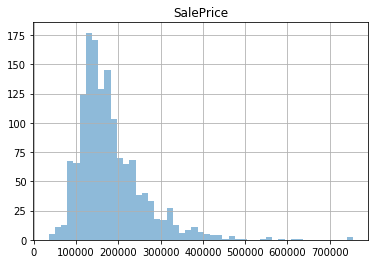

In [9]:
            # Histogram of sale prices
            plt.figure()
            house_prices.df[['SalePrice']].hist(bins='auto', alpha=.5)
            plt.show()

<Figure size 432x288 with 0 Axes>

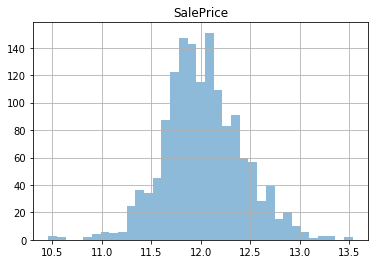

In [10]:
            # Histogram of sale prices after data munging
            plt.figure()
            df[['SalePrice']].hist(bins='auto', alpha=.5)
            plt.show()

We could ask the question in what month or in what year are most
houses sold?

<Figure size 432x288 with 0 Axes>

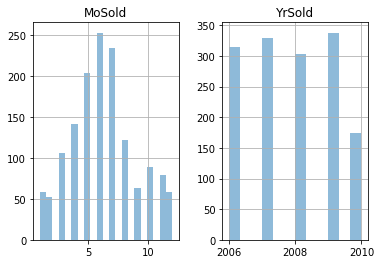

In [11]:
            # We expect more houses to be sold in the summer. Which is also the 
            # case month MM, year YYYY.
            # Sale tops in juli
            plt.figure()
            house_prices.df[['MoSold', 'YrSold']].hist(bins='auto', alpha=.5)
            plt.show()

Two heatmaps showing correlations between features before and after 
data munging. In the second plot a lot more features occur, since
categorical features have been transformed to numerical.
Although it may be a little difficult to read the names of the many features in the second plot,
it can still give an overview. Notice that sale price is the last feature occurring
on both axes.

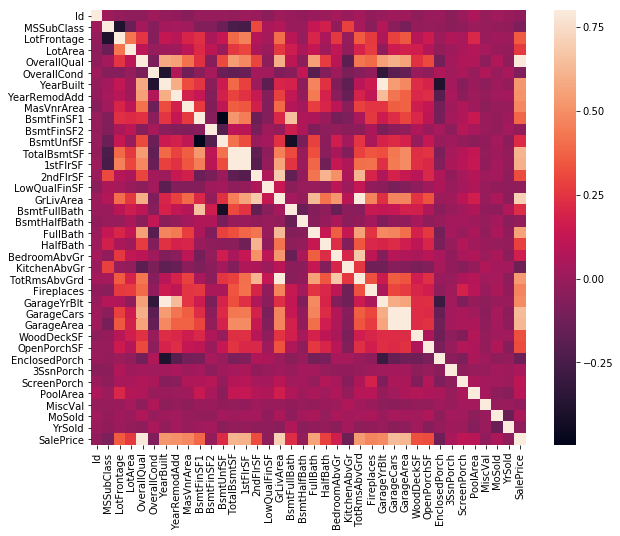

In [12]:
        # Categorical plot with seaborn
        is_categorical_plot = 1
        if is_categorical_plot:
            # sns.countplot(y='MSZoning', hue='MSSubClass', data=df, palette='Greens_d')
            # plt.show()
            # sns.stripplot(x='SalePrice', y='MSZoning', data=df, jitter=True, hue='LandContour')
            # plt.show()
            # sns.boxplot(x='SalePrice', y='MSZoning', data=df, hue='MSSubClass')
            # plt.show()
            
            # Heatmap of feature correlations
            plt.figure(figsize=(10, 8))
            correlations = house_prices.df.corr()
            sns.heatmap(correlations, vmax=0.8, square=True)
            plt.show()

            # plt.figure()
            # sns.stripplot(x='SalePrice', y='OverallQual', data=house_prices.df, jitter=True)
            # plt.show()

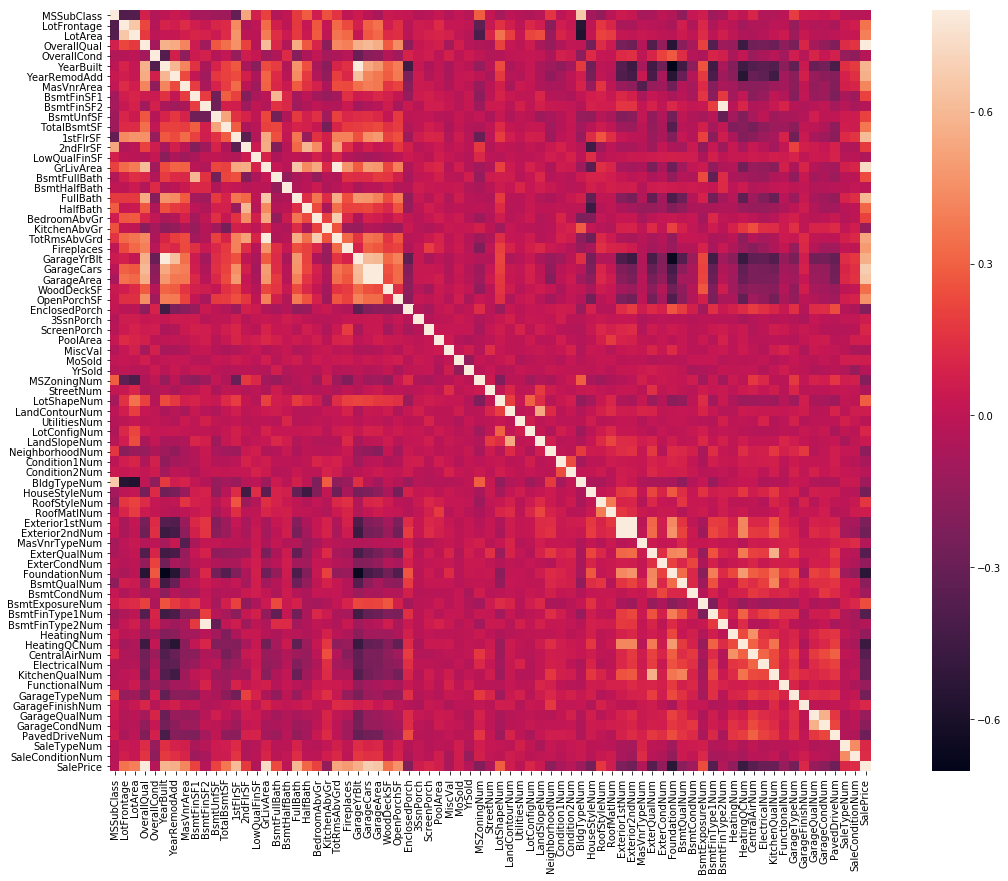

In [13]:
            # Heatmap of feature correlations after data munging
            plt.figure(figsize=(22, 14))
            correlations = df[house_prices.extract_numerical_features(df)].corr()
            sns.heatmap(correlations, vmax=0.8, square=True)
            plt.show()

Some features are highly correlated and it may therefore improve predictions if we apply feature agglomeration to our data

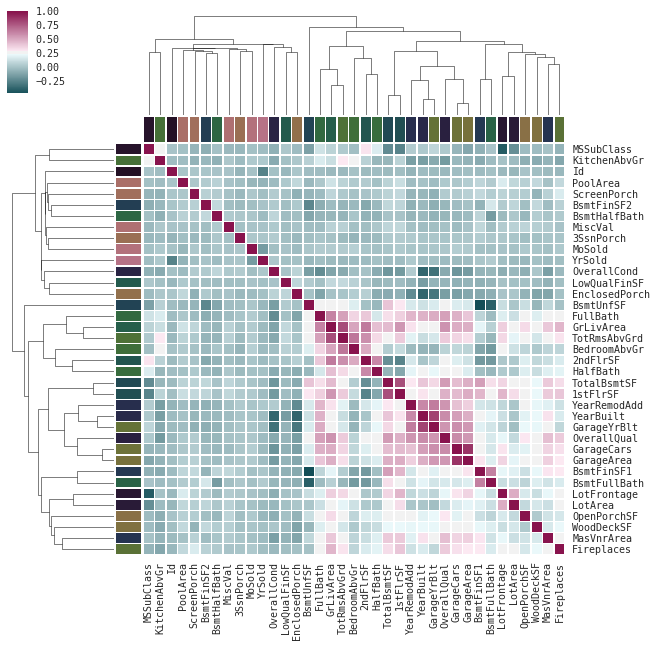

In [14]:
            # Plot of agglomerated features in heatmap before data munging
            num_features = house_prices.extract_numerical_features(house_prices.df_test)
            
            
            df_merged_train_and_test_before_munging = pd.DataFrame(
                data=np.concatenate((house_prices.df[house_prices.df.columns[
                    house_prices.df.columns != 'SalePrice']].values, 
                                     house_prices.df_test.values)), columns=house_prices.df_test.columns)
            HousePrices.dendrogram(df_merged_train_and_test_before_munging[num_features])

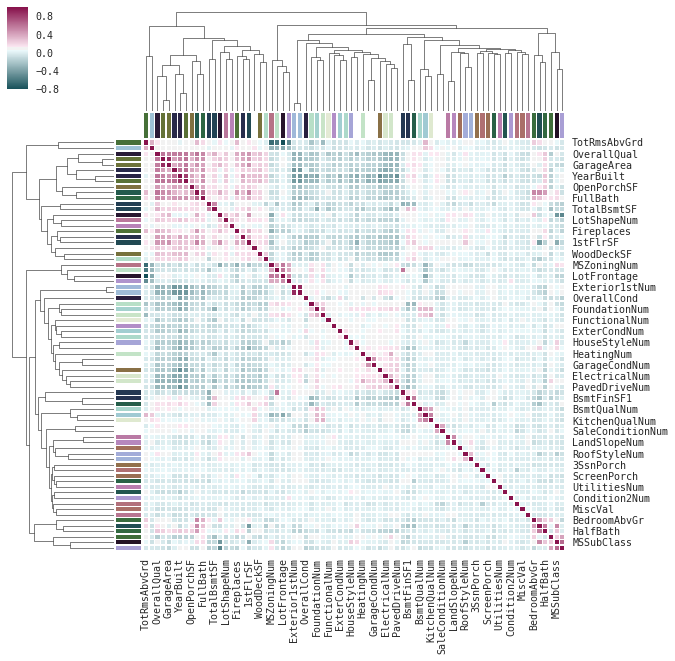

In [15]:
            # Plot of agglomerated features in heatmap after data munging
            HousePrices.dendrogram(df_merged_train_and_test)

With a heatmap we are able to discover how much some features depend on the sale price.
Sale price is indicated inside each small box and color scale is one the right.

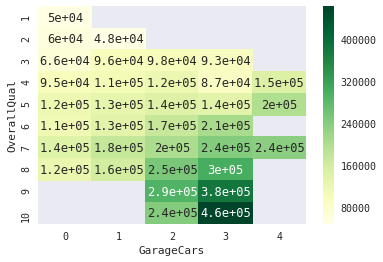

In [16]:
            # Produce a heatmap with coefficients
            plt.figure()
            heat_data = house_prices.df.pivot_table(values='SalePrice', index=['OverallQual'], 
                                                    columns=['GarageCars'])
            htmp = sns.heatmap(heat_data, annot=True, cmap='YlGn')
            plt.show()

Another convenient way to use a heatmap is by showing correlation coefficients 
between features. This makes it easy to see what is very much correlated with 
sale price and what features are less correlated.
Two plots are shown for cases before and after data munging.
Notice the white empty lines in the first plot occur due to missing values.

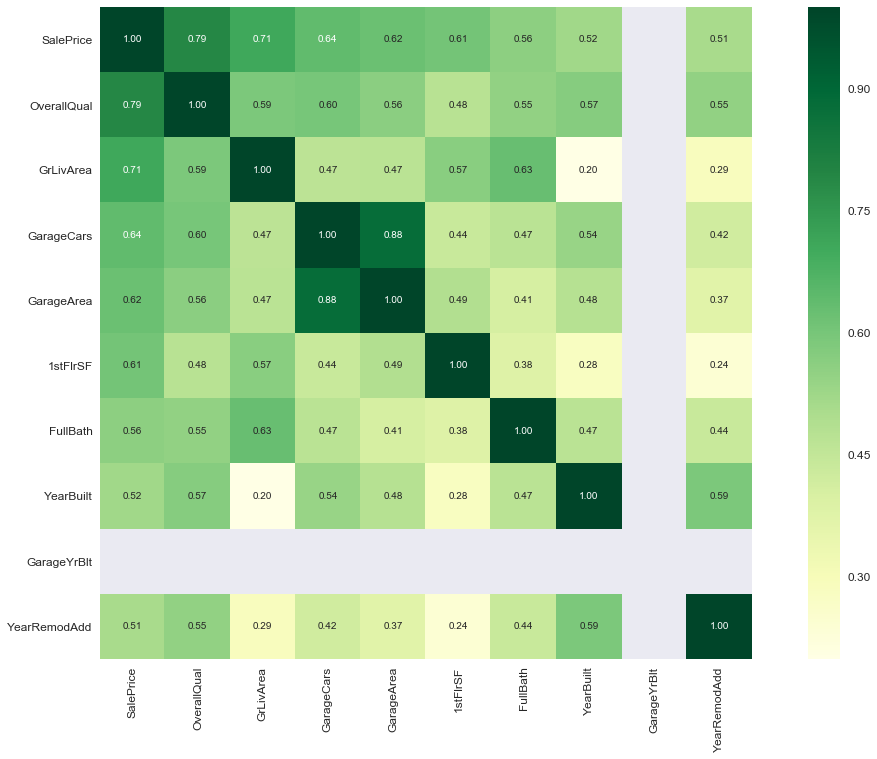

In [17]:
            # Zoom of heatmap with coefficients
            plt.figure(figsize=(20, 12))
            top_features = 10
            columns = correlations.nlargest(top_features, 'SalePrice')['SalePrice'].index
            correlation_coeff = np.corrcoef(house_prices.df[columns].values.T)
            sns.set(font_scale=1.20)
            coeff_heatmap = sns.heatmap(correlation_coeff, annot=True, cmap='YlGn', cbar=True, 
                                        square=True, fmt='.2f', annot_kws={'size': 10}, 
                                        yticklabels=columns.values, xticklabels=columns.values)
            plt.show()
            plt.close()

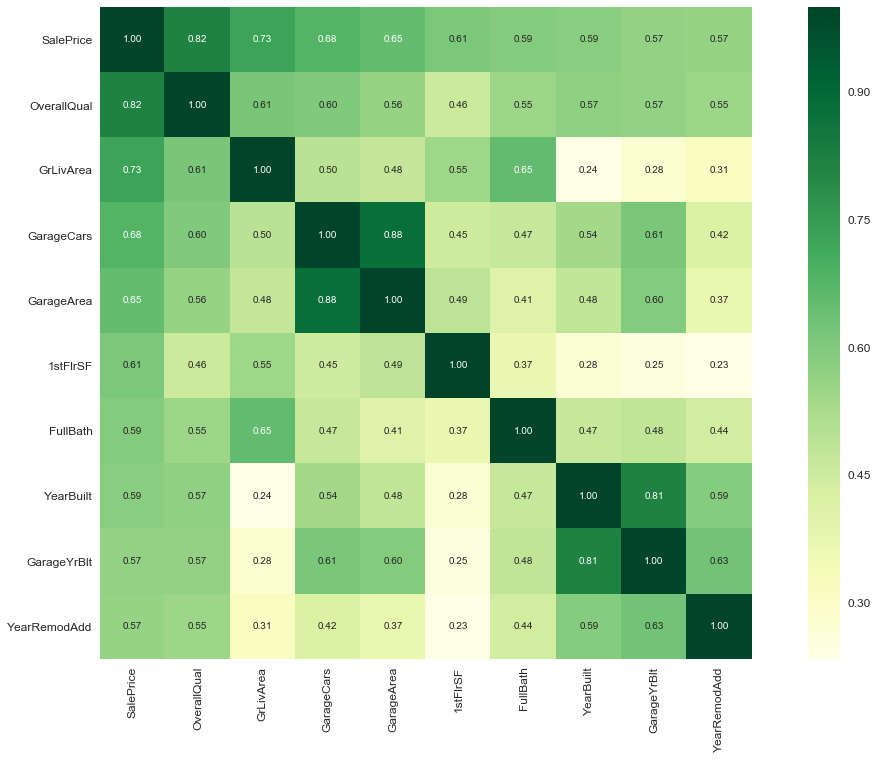

In [18]:
            # Zoom of heatmap with coefficients after data munging
            plt.figure(figsize=(20, 12))
            top_features = 10
            columns = correlations.nlargest(top_features, 'SalePrice')['SalePrice'].index
            correlation_coeff = np.corrcoef(df[columns].values.T)
            sns.set(font_scale=1.20)
            coeff_heatmap = sns.heatmap(correlation_coeff, annot=True, cmap='YlGn', cbar=True, 
                                        square=True, fmt='.2f', annot_kws={'size': 10}, 
                                        yticklabels=columns.values, xticklabels=columns.values)
            plt.show()
            plt.close()

A boxplot is a good way to visualize how our data is positioned with 
respect to sale price and to indicate the mean value, which is
shown by a straight line inside each box.

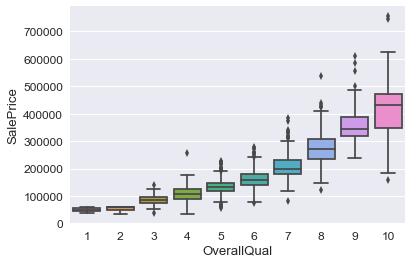

In [19]:
            plt.figure()
            sns.boxplot(y='SalePrice', x='OverallQual', data=house_prices.df)
            plt.show()

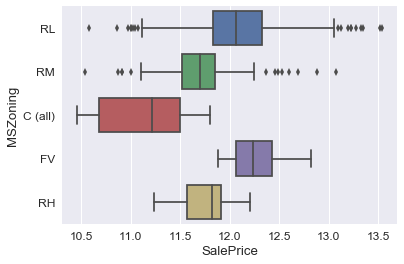

In [20]:
            plt.figure()
            sns.boxplot(x='SalePrice', y='MSZoning', data=df)
            plt.show()

We expect that house price may highly depend on neighborhood. In estate business location is a very important element.

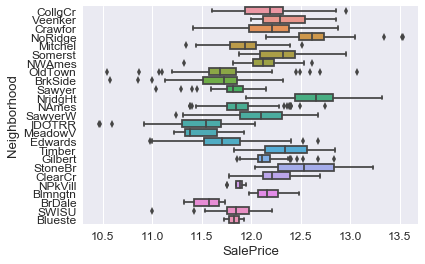

In [21]:
            plt.figure()
            sns.boxplot(x='SalePrice', y='Neighborhood', data=df)
            plt.show()

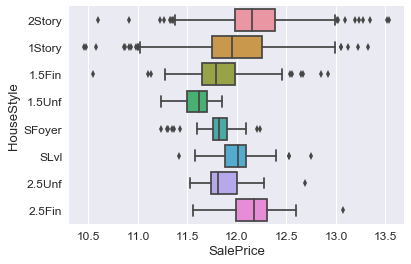

In [22]:
            
            plt.figure()
            sns.boxplot(x='SalePrice', y='HouseStyle', data=df)
            plt.show()

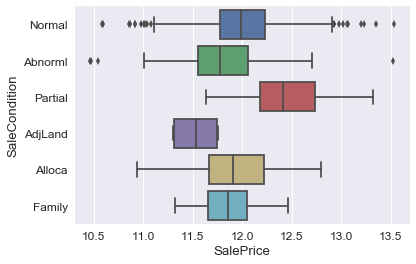

In [23]:
            
            plt.figure()
            sns.boxplot(x='SalePrice', y='SaleCondition', data=df)
            plt.show()

C:\Users\Lourdes\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


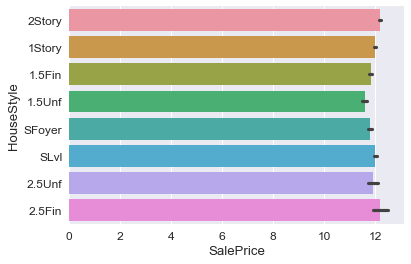

In [24]:
            # sns.violinplot(x='SalePrice', y='MSZoning', data=df)
            # plt.show()
            # sns.violinplot(x='SalePrice', y='Neighborhood', data=df)
            # plt.show()

            # Arbitrary estimate, using the mean by default.
            # It also uses bootstrapping to compute a confidence interval around the estimate 
            # and plots that using error bars
            # sns.barplot(x='SalePrice', y='MSZoning', hue='LotShape', data=df)
            # plt.show()
            # sns.barplot(x='SalePrice', y='Neighborhood', data=df)#, hue='LotShape')
            # plt.show()
            # sns.barplot(x='SalePrice', y='SaleCondition', data=df)#, hue='LotShape')
            # plt.show()
            
            plt.figure()
            sns.barplot(x='SalePrice', y='HouseStyle', data=df)#, hue='LotShape')
            plt.show()

Let us plot a few features and study them with respect to SalePrice and GrLivArea.

C:\Users\Lourdes\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


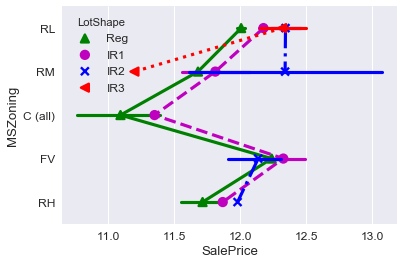

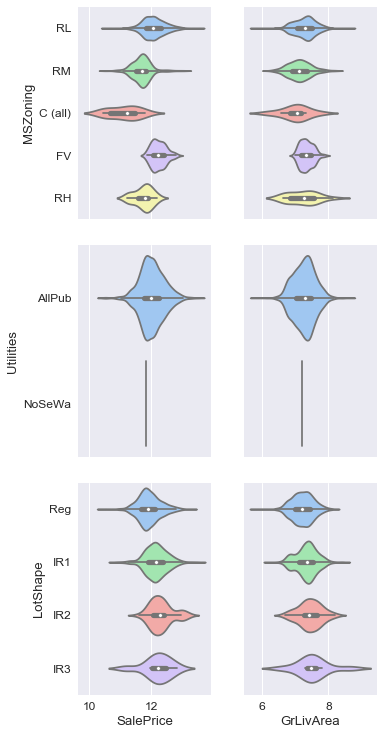

In [25]:
            sns.pointplot(x='SalePrice', y='MSZoning', hue='LotShape', data=df,
                          palette={"Reg": "g", "IR1": "m", "IR2": "b", "IR3": "r"}, 
                          markers=["^", "o", 'x', '<'], 
                          linestyles=["-", "--", '-.', ':'])
            plt.show()

            g = sns.PairGrid(df, x_vars=['SalePrice', 'GrLivArea'], y_vars=['MSZoning', 'Utilities', 
                                                                          'LotShape'], 
                             aspect=.75, size=3.5)
            g.map(sns.violinplot, palette='pastel')
            plt.show()

            # Quite slow
            # sns.swarmplot(x='MSZoning', y='MSSubClass', data=df, hue='LandContour')
            # plt.show()

It is important to study if our regularized linear models are able to find optimal 
regularization parameters alpha. A good parameter is able to prevent overfitting
in case of high variance data.

Best Ridge alpha: 0.3
Best Lasso alpha: 0.0005


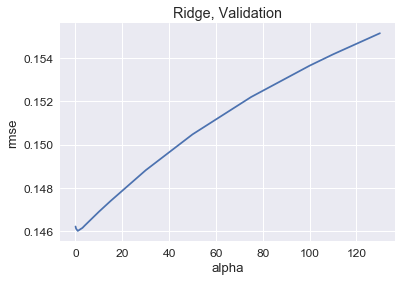


Ridge optimal regularization parameter alpha has rmse = 
0.14599832987468367


In [26]:
       is_choose_optimal_regularization_param = 1
       if is_choose_optimal_regularization_param:
            # Choose optimal value for alpha (regularization parameter) in Lasso and Ridge
            x_train = train_data[0::, :-1]
            y_train = train_data[0::, -1]
            alphas = [0.05, 0.1, 0.3, 1, 3, 4, 10, 15, 30, 50, 75, 100, 110, 130]

            ridge = RidgeCV(alphas=alphas)
            ridge.fit(x_train, y_train)
            alpha = ridge.alpha_
            print("Best Ridge alpha:", alpha)

            alphas_lasso = [1e-6, 1e-5, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.03, 0.06, 0.09, 
                            0.1, 0.15] 
            # [1, 0.1, 0.001, 0.0005]
            lasso = LassoCV(alphas=alphas_lasso)
            lasso.fit(x_train, y_train)
            alpha = lasso.alpha_
            print("Best Lasso alpha:", alpha)

            cv_ridge = [house_prices.rmse_cv(Ridge(alpha=alpha), x_train, y_train).mean() 
                        for alpha in alphas]
            cv_ridge = pd.Series(np.expm1(cv_ridge), index=alphas)
            cv_ridge = pd.Series(cv_ridge, index=alphas)
            plt.figure()
            cv_ridge.plot(title = "Ridge, Validation")
            plt.xlabel('alpha')
            plt.ylabel('rmse')
            plt.show()
            print("\nRidge optimal regularization parameter alpha has rmse = ")
            print(cv_ridge.min())

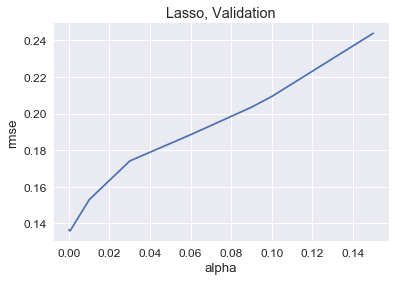

In [27]:
            # cv_lasso = [house_prices.rmse_cv(LassoCV(alphas=[alpha]), x_train, y_train).mean() 
            # for alpha in alphas_lasso]
            cv_lasso = [house_prices.rmse_cv(Lasso(alpha=alpha), x_train, y_train).mean() 
                        for alpha in alphas_lasso]
            # cv_lasso = pd.Series(np.expm1(cv_lasso), index=alphas_lasso)
            cv_lasso = pd.Series(cv_lasso, index=alphas_lasso)
            plt.figure()
            cv_lasso.plot(title="Lasso, Validation")
            plt.xlabel('alpha')
            plt.ylabel('rmse')
            plt.show()

In [28]:
            print("\nLasso optimal regularization parameter alpha has rmse = ")
            print(cv_lasso.min())

            print("\nMean lasso rmse:")
            model_lasso = LassoCV(alphas=alphas_lasso).fit(x_train, y_train)
            print(house_prices.rmse_cv(model_lasso, x_train, y_train).mean())
            print("\nbest lasso alpha:", model_lasso.alpha_)


Lasso optimal regularization parameter alpha has rmse = 
0.13585523724468668

Mean lasso rmse:
0.13585523724468668

best lasso alpha: 0.0005


We want to make sure that a potential machine learning estimator will form a model
based on some features that are highly correlated with sale price.

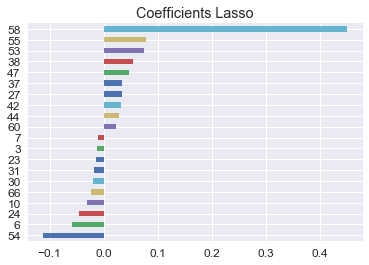

In [29]:
            if is_with_agglomeration:
                coefficient_lasso = pd.Series(model_lasso.coef_, 
                                              index=df_merged_train_and_test_agglom
                                              .columns).sort_values()
            else:
                coefficient_lasso = pd.Series(model_lasso.coef_, 
                                              index=df_test_num_features).sort_values()
            
            importance_coeff = pd.concat([coefficient_lasso.head(10), coefficient_lasso.tail(10)])
            plt.figure()
            importance_coeff.plot(kind='barh')
            plt.title('Coefficients Lasso')
            plt.show()

Make Predictions using Machine Learning Estimators 
----------
Let us finally make predictions on sale price using our machine learning estimators XGBoost, LassoCV and RidgeCV.
To see how well our model does, we have created a test using cross validation, where we
split our training data set in two parts to compare predicted vs. actual sale price.
The points should be close to the line and we want lowest possible rmse (root mean square error).
Furthermore, we also examine if feature selection (feature variance threshold) improves results with our regularized linear models.


Prediction Stats:

Outlier shapes
(1095, 67) (365, 67) (1095,) (365,)
(1052, 67) (351, 67) (1052,) (351,)


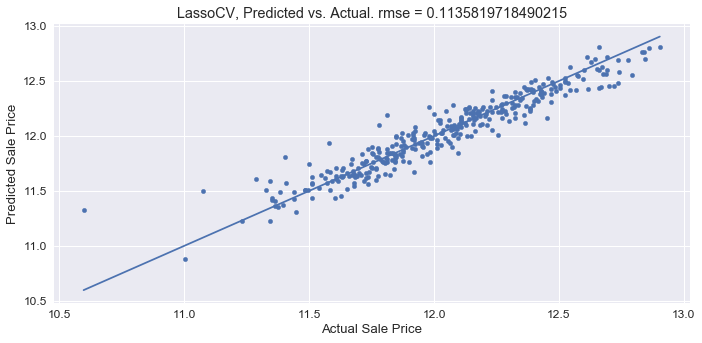

best LassoCV alpha: 0.0003

SCORE Lasso linear model:---------------------------------------------------
0.9175387149783657


In [30]:
    is_make_a_prediction = 1
    if is_make_a_prediction:
        ''' XGBoost and Regularized Linear Models and Random Forest '''
        print("\nPrediction Stats:")
        x_train = train_data[0::, :-1]
        y_train = train_data[0::, -1]

        # Regularized linear regression is needed to avoid overfitting even if you 
        # have lots of features
        lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 
                                0.1, 0.3, 0.6, 1],
                        max_iter=50000, cv=10)

        # Exclude outliers
        x_train, y_train = house_prices.outlier_identification(lasso, x_train, y_train)
        # plt.show()
        # Feature selection with Lasso
        # Make comparison plot using only the train data.
        # Predicted vs. Actual Sale price
        title_name = 'LassoCV'
        house_prices.predicted_vs_actual_sale_price_input_model(lasso, x_train, y_train, 
                                                                title_name)
        plt.show()
        # plt.close()
        lasso.fit(x_train, y_train)
        alpha = lasso.alpha_
        print('best LassoCV alpha:', alpha)
        score = lasso.score(x_train, y_train)
        output_lasso = lasso.predict(test_data)
        print('\nSCORE Lasso linear model:---------------------------------------------------')
        print(score)

(1052, 67) (351, 67) (1052,) (351,)


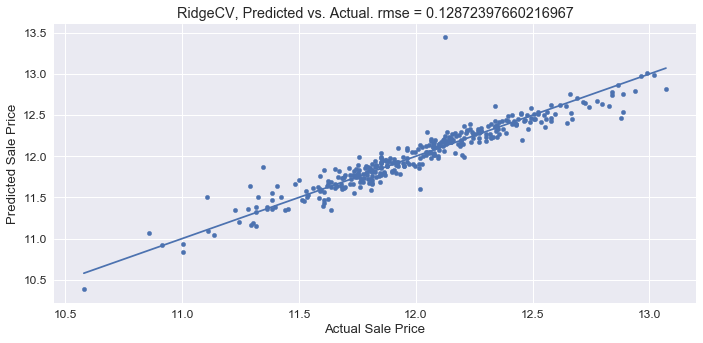

best RidgeCV alpha: 0.3

SCORE Ridge linear model:--------------------------------------------------
0.9180037533684114


In [31]:
        is_ridge_estimator = 1
        if is_ridge_estimator:
            ridge = RidgeCV(alphas=[0.06, 0.1, 0.3, 0.6, 1, 10, 100, 110], cv=10)
            title_name = 'RidgeCV'
            house_prices.predicted_vs_actual_sale_price_input_model(ridge, x_train, y_train, 
                                                                    title_name)
            plt.show()
            ridge.fit(x_train, y_train)
            alpha = ridge.alpha_
            print('best RidgeCV alpha:', alpha)
            score = ridge.score(x_train, y_train)
            output_ridge = ridge.predict(test_data)
            print('\nSCORE Ridge linear model:--------------------------------------------------')
            print(score)

(1403, 17)
(1459, 17)
(1052, 17) (351, 17) (1052,) (351,)


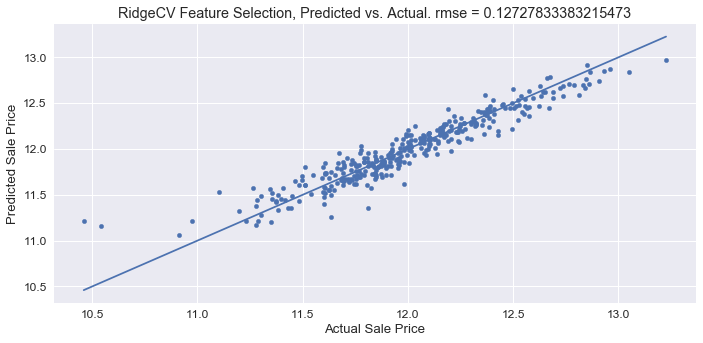


SCORE RidgeCV regressor (feature select):--------------------------------------
0.892945292150923


In [32]:
            # Make comparison plot using only the train data.
            # Predicted vs. Actual Sale price
            add_name_of_regressor = 'RidgeCV'
            forest_feature_selection = ridge

            # Select most important features
            feature_selection_model = SelectFromModel(forest_feature_selection, prefit=True)
            x_train_new = feature_selection_model.transform(x_train)
            print(x_train_new.shape)
            test_data_new = feature_selection_model.transform(test_data)
            print(test_data_new.shape)
            # We get that 21 features are selected

            title_name = ''.join([add_name_of_regressor, ' Feature Selection'])
            house_prices.predicted_vs_actual_sale_price_input_model(forest_feature_selection, 
                                                                    x_train_new, y_train, 
                                                                    title_name)
            plt.show()
            forest_feature_selected = forest_feature_selection.fit(x_train_new, y_train)
            score = forest_feature_selected.score(x_train_new, y_train)
            output_feature_selection_ridge = forest_feature_selection.predict(test_data_new)
            print('\nSCORE {0} regressor (feature select):--------------------------------------'
                  .format(add_name_of_regressor))
            print(score)

In [33]:
        is_grid_search_RF_prediction = 0
        if is_grid_search_RF_prediction:
            # Fit the training data to the survived labels and create the decision trees

            # Create the random forest object which will include all the parameters for the fit
            forest = RandomForestRegressor()
            # forest = SGDRegressor()
            parameter_grid = {'max_depth': [4,5,6,7,8], 'n_estimators': [200,210,240,250]}  
            # ,'criterion': ['gini', 'entropy']}
            cross_validation = StratifiedKFold(random_state=None, shuffle=False)  # , n_folds=10)
            grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=cross_validation, 
                                       n_jobs=24)
            title_name = 'Random Forest with GridSearchCV'
            house_prices.predicted_vs_actual_sale_price_input_model(grid_search, x_train, y_train, 
                                                                    title_name)
            plt.show()
            grid_search.fit(x_train, y_train)
            # output = grid_search.predict(test_data)

            print('Best score: {}'.format(grid_search.best_score_))
            print('Best parameters: {}'.format(grid_search.best_params_))

(1403, 60)
(1459, 60)
(1052, 60) (351, 60) (1052,) (351,)


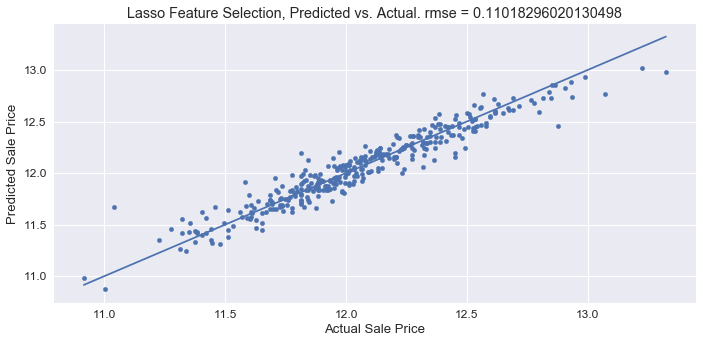


SCORE Lasso regressor (feature select):-------------------------------------
0.9178674642982396


In [34]:
        is_feature_selection_prediction = 1
        if is_feature_selection_prediction:

            is_feature_selection_with_lasso = 1
            if is_feature_selection_with_lasso:
                forest_feature_selection = lasso
                add_name_of_regressor = 'Lasso'
            else:
                add_name_of_regressor = 'Random Forest'
                # Random forest (rf) regressor for feature selection
                forest_feature_selection = RandomForestRegressor(n_estimators=240, max_depth=8)
                forest_feature_selection = forest_feature_selection.fit(x_train, y_train)

                # Evaluate variable importance with no cross validation
                importances = forest_feature_selection.feature_importances_
                std = np.std([tree.feature_importances_ for tree 
                              in forest_feature_selection.estimators_], axis=0)
                indices = np.argsort(importances)[::-1]

                print('\nFeatures:')
                df_test_num_features = house_prices.extract_numerical_features(df_test)
                print(np.reshape(
                    np.append(np.array(list(df_test_num_features)), 
                              np.arange(0, len(list(df_test_num_features)))), 
                    (len(list(df_test_num_features)), 2), 'F'))  # , 2, len(list(df_test)))

                print('\nFeature ranking:')
                for f in range(x_train.shape[1]):
                    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))

            # Select most important features
            feature_selection_model = SelectFromModel(forest_feature_selection, prefit=True)
            x_train_new = feature_selection_model.transform(x_train)
            print(x_train_new.shape)
            test_data_new = feature_selection_model.transform(test_data)
            print(test_data_new.shape)
            # We get that 21 features are selected

            title_name = ''.join([add_name_of_regressor, ' Feature Selection'])
            house_prices.predicted_vs_actual_sale_price_input_model(forest_feature_selection, 
                                                                    x_train_new, y_train, 
                                                                    title_name)
            plt.show()
            forest_feature_selected = forest_feature_selection.fit(x_train_new, y_train)
            score = forest_feature_selected.score(x_train_new, y_train)
            output_feature_selection_lasso = forest_feature_selection.predict(test_data_new)
            print('\nSCORE {0} regressor (feature select):-------------------------------------'
                  .format(add_name_of_regressor))
            print(score)

In [35]:
        ''' xgboost '''
        is_xgb_cv = 1
        if is_xgb_cv:
            seed = 0
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dtest = xgb.DMatrix(test_data)

            xgb_params = {
                'seed': 0,
                'colsample_bytree': 0.8,
                'silent': 1,
                'subsample': 0.6,
                'learning_rate': 0.01,
                # 'booster': 'gblinear',  # default is gbtree
                'objective': 'reg:linear',
                'max_depth': 1,
                'num_parallel_tree': 1,
                'min_child_weight': 1,
                'eval_metric': 'rmse',
            }

            res = xgb.cv(xgb_params, dtrain, num_boost_round=500, nfold=10, seed=seed, 
                         stratified=False, early_stopping_rounds=25, verbose_eval=10, 
                         show_stdv=True)

            best_nrounds = res.shape[0] - 1
            cv_mean = res.iloc[-1, 0]
            cv_std = res.iloc[-1, 1]

            print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))
            title_name = 'xgb.cv'
            # house_prices.predicted_vs_actual_sale_price_xgb(xgb, best_nrounds, xgb_params, 
            # x_train, y_train, title_name)
            gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
            output_xgb_cv = gbdt.predict(dtest)

[0]	train-rmse:11.4146+0.00307435	test-rmse:11.4146+0.0274644
[10]	train-rmse:10.3259+0.00281611	test-rmse:10.3259+0.0277456
[20]	train-rmse:9.34136+0.00243757	test-rmse:9.34134+0.0281573
[30]	train-rmse:8.45092+0.00195364	test-rmse:8.45089+0.0286796
[40]	train-rmse:7.64568+0.00179342	test-rmse:7.64565+0.0288897
[50]	train-rmse:6.91754+0.00181687	test-rmse:6.91756+0.0287952
[60]	train-rmse:6.25881+0.00170312	test-rmse:6.25879+0.0278612
[70]	train-rmse:5.66316+0.00147204	test-rmse:5.66318+0.0274855
[80]	train-rmse:5.12443+0.0013369	test-rmse:5.12427+0.0267309
[90]	train-rmse:4.63717+0.00125034	test-rmse:4.63698+0.026209
[100]	train-rmse:4.19638+0.00117962	test-rmse:4.1962+0.025833
[110]	train-rmse:3.79782+0.00106411	test-rmse:3.79764+0.0253505
[120]	train-rmse:3.4375+0.00103775	test-rmse:3.43733+0.0249384
[130]	train-rmse:3.1116+0.000948923	test-rmse:3.11153+0.0247139
[140]	train-rmse:2.81693+0.000984126	test-rmse:2.81687+0.0242951
[150]	train-rmse:2.55031+0.000943952	test-rmse:2.55038+

In [36]:
        use_xgb_regressor = 0
        if use_xgb_regressor:
            # Is a parallel job
            xgb_model = xgb.XGBRegressor()
            # xgb_model = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1)
            # XGBClassifier gives the best prediction
            # xgb_model = xgb.XGBClassifier()
            cross_validation = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)  
            # , n_folds=10)
            parameter_grid = {'max_depth': [4, 5, 6, 7, 8], 'n_estimators': [200, 210, 240, 250]}
            # parameter_grid = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}  
            # , 'criterion': ['gini'
            # , 'entropy']}
            clf = GridSearchCV(xgb_model, param_grid=parameter_grid, cv=cross_validation)  
            # verbose=1)
            title_name = 'xgbRegressor'
            house_prices.predicted_vs_actual_sale_price_input_model(clf, x_train, y_train, 
                                                                    title_name)
            clf.fit(x_train, y_train)
            output_xgb_regressor = clf.predict(test_data)
            print('\nSCORE XGBRegressor train data:-------------------------------------------')
            print(clf.best_score_)
            print(clf.best_params_)

In [37]:
        # house_prices.timestamp = datetime.datetime.now().strftime('%Y%m%d_%Hh%Mm%Ss')
        # save_path = '/home/user/predicted_vs_actual/'
        # house_prices.multipage(''.join([save_path, 'Overview_estimators_rmse_', 
        #                                house_prices.timestamp, '.pdf']))
        # plt.close()

In [38]:
        # Averaging the output using four different machine learning estimators
        # output = (output_feature_selection_lasso + output_feature_selection_ridge + output_xgb_cv
        # + output_xgb_regressor)/4.0
        # output = (output_feature_selection_lasso + output_ridge + output_xgb_regressor) / 3.0
        # output = (output_feature_selection_lasso + output_ridge) / 2.0
        output = (output_feature_selection_lasso + output_xgb_cv) / 2.0
        # print np.shape(output_ridge) == np.shape(output_lasso)

Submission 
----------

In [39]:
    if is_make_a_prediction:
        ''' Submission '''
        # Submission requires a csv file with Id and SalePrice columns.
        # dfBestScore = pd.read_csv(''.join([save_path, 'submission_house_prices.csv']), header=0)

        # We do not expect all to be equal since the learned model differs from time to time.
        # print (dfBestScore.values[0::, 1::].ravel() == output.astype(int))
        # print np.array_equal(dfBestScore.values[0::, 1::].ravel(), output.astype(int))  
        # But they are almost never all equal

        # Exp() is needed in order to get the correct sale price, since we took a log() earlier
        # if not is_simple_model:
        if house_prices.is_with_log1p_SalePrice:
            output = np.expm1(output)
            
        submission = pd.DataFrame({'Id': Id_df_test, 'SalePrice': output})
        submission.to_csv(''.join(['submission_house_prices_', house_prices.timestamp, 
                                   '.csv']), index=False)